In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob 
from plotly.subplots import make_subplots
from datetime import datetime

## 💾 Carga de Datos

In [5]:
def data_upload():
    csv_files = glob.glob('./Cambridge_csv/*.csv')
    mean_altitude = np.zeros([1, 117])
    for file in csv_files:mean_altitude += np.array(pd.read_csv(file)['altitude'])
    mean_altitude = mean_altitude / len(csv_files)
    # Convetir a Dataframe
    Data = pd.DataFrame(mean_altitude.T, columns=['altitude'])
    Data.index = range(1, len(Data) + 1)
    return Data

## 🌍 Variables Físicas

In [6]:
def alt_tmp(z):
    #La altitud z debe estar en metros.
    if (z<11019):
        z0,T0,lambda0,P0 = (0,288.15,-0.0065,101325.0)
        return T0 + lambda0 * (z - z0)

    elif (z<20063):
        z0,T0 = (11019,216.65)
        return T0 

    elif (z < 32162):
        z0,T0,lambda0,P0= (20063,216.65,0.0010,5474.89)
        return T0 + lambda0 * (z - z0)

    elif (z < 47359):
        z0,T0,lambda0,P0= (32162,228.65,0.0028,868.02)
        return T0 + lambda0 * (z - z0)

def alt_gravity(z):
    G0, RE = (9.80665, 6371000)
    return G0 * ((RE / (RE + z)) ** 2)

def alt_pressure(z):
    
    t = alt_tmp(z)
    g = alt_gravity(z)

    if (z<11019):
        z0, T0, lambda0,P0 = (0,288.15,-0.0065,101325.0)
        return  P0 * ((T0 / t) ** (g * 0.0289644 / (8.31432 * lambda0)))

    elif (z<20063):
        z0, T0,P0 =(11019,216.65,22632.10) 
        return P0 * np.exp(- g * 0.0289644 * (z - z0) / (8.31432 * t))

    elif (z<32162):
        z0 = 20063
        T0 = 216.65
        lambda0 = 0.0010
        P0 = 5474.89
        return P0 * ((T0 / t) ** (g * 0.0289644 / (8.31432 * lambda0)))

    elif (z<47359):
        z0, T0, lambda0,P0 = (32162,228.65,0.0028,868.02)
        return P0 * ((T0 / t) ** (g * 0.0289644 / (8.31432 * lambda0)))

## 📄 Cálculos Matemáticos


In [7]:
def calculus(Data):
    
    # Recorrido lineal 0 a 30,000 m 
    Altitude=np.linspace(0,30000)
    Temperature=np.array(list(map(alt_tmp,Altitude)))
    Pressure= np.array(list(map(alt_pressure,Altitude)))

    sim_altitude=np.array(Data.altitude)
    sim_time=np.linspace(1,sim_altitude.size,sim_altitude.size)
    sim_temperature=np.array(list(map(alt_tmp,sim_altitude)))
    sim_pressure= np.array(list(map(alt_pressure,sim_altitude)))

    # Velocidad: Posicion
    dx=np.diff(sim_altitude)
    dt=np.diff(sim_time)
    v=dx/dt
    sim_time2=np.linspace(1,v.size,v.size)

    # Velocidad: Temperatura
    dT=np.diff(sim_temperature)
    dTT=dT/dt

    # Velocidad: Presion
    dP=np.diff(sim_pressure)
    dPP=dP/dt

    # Aceleracion: Posicion
    dx2=np.diff(v)
    dt2=np.diff(sim_time2)
    v2=dx2/dt2
    sim_time3=np.linspace(1,v2.size,v2.size)

    # Aceleracion: Temperatura
    dT2=np.diff(dTT)
    dTT2=dT2/dt2

    # Aceleracion: Presion
    dP2=np.diff(dPP)
    dPP2=dP2/dt2
    return sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3

## 📈 Gráficas

In [8]:
def graphics1(formatted_datetime,sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3):
    fig, axs = plt.subplots(3, 3, figsize=(14, 8))
    # Referencia: Temperatura vs Altitud
    # axs[0, 0].plot(Altitude/1000, Temperature-273.15)
    # axs[0, 0].set_title('Referencia ISA: Temperatura vs Altitud')
    # axs[0, 0].set_xlabel('Altitud [km]', fontsize=14)
    # axs[0, 0].set_ylabel('Temperatura [°C]', fontsize=14)
    
    # # Referencia: Presión vs Altitud
    # axs[0, 1].plot(Altitude/1000, 14.6959*(1-Pressure/101325))
    # axs[0, 1].set_title('Referencia ISA: Presión de vacío vs Altitud')
    # axs[0, 1].set_xlabel('Altitud [km]', fontsize=14)
    # axs[0, 1].set_ylabel('Presión [psi]', fontsize=14)
    
    # Altura vs Tiempo
    axs[0, 2].plot(sim_time, sim_altitude/1000)
    axs[0, 2].set_title('Simulación: Altura vs Tiempo')
    axs[0, 2].set_xlabel('Tiempo [Min]', fontsize=14)
    axs[0, 2].set_ylabel('Altitud [metros]', fontsize=14)
    
    # Temperatura vs Tiempo
    axs[0, 0].plot(sim_time, sim_temperature-273.15)
    axs[0, 0].set_title('Simulación: Temperatura vs Tiempo')
    axs[0, 0].set_xlabel('Tiempo [Min]', fontsize=14)
    axs[0, 0].set_ylabel('Temperatura [°C]', fontsize=14)
    
    # Presión vs Tiempo
    axs[0, 1].plot(sim_altitude/1000, 14.6959*(1-sim_pressure/101325))
    axs[0, 1].set_title('Simulación: Presión de vacío vs Tiempo')
    axs[0, 1].set_xlabel('Tiempo [Min]', fontsize=14)
    axs[0, 1].set_ylabel('Presión [psi]', fontsize=14)
    
    # dT vs Tiempo
    axs[1, 0].plot(sim_time2,dTT)
    axs[1, 0].set_title('Simulación: dTemperatura vs Tiempo')
    axs[1, 0].set_xlabel('Tiempo [Min]', fontsize=14)
    axs[1, 0].set_ylabel('dT [°C/min]', fontsize=14)
    
    # dP vs Tiempo
    axs[1, 1].plot(sim_time2,dPP)
    axs[1, 1].set_title('Simulación: dPresion de vacío vs Tiempo')
    axs[1, 1].set_xlabel('Tiempo [Min]', fontsize=14)
    axs[1, 1].set_ylabel('dP [psi/min]', fontsize=14)
    
    # Velocidad vs Tiempo
    axs[1, 2].plot(sim_time2,v)
    axs[1, 2].set_title('Simulación: Velocidad vs Tiempo')
    axs[1, 2].set_xlabel('Tiempo [Min]', fontsize=14)
    axs[1, 2].set_ylabel('Velocidad [m/min]', fontsize=14)
    
    # d2T vs Tiempo
    axs[2, 0].plot(sim_time3,dTT2)
    axs[2, 0].set_title('Simulación: d2Temperatura vs Tiempo')
    axs[2, 0].set_xlabel('Tiempo [Min]', fontsize=14)
    axs[2, 0].set_ylabel('dT [°C/min2]', fontsize=14)
    
    # d2P vs Tiempo
    axs[2, 1].plot(sim_time3,dPP2)
    axs[2, 1].set_title('Simulación: d2Presion de vacío vs Tiempo')
    axs[2, 1].set_xlabel('Tiempo [Min]', fontsize=14)
    axs[2, 1].set_ylabel('dP [psi/min2]', fontsize=14)
    
    # Aceleracion vs Tiempo
    axs[2, 2].plot(sim_time3,v2)
    axs[2, 2].set_title('Simulación: Aceleración vs Tiempo')
    axs[2, 2].set_xlabel('Tiempo [Min]', fontsize=14)
    axs[2, 2].set_ylabel('Aceleración [m/min2]', fontsize=14)
    
    # Mostrar resultados
    plt.suptitle("Variables: Prueba vacío térmico")
    plt.tight_layout()
    Picture_name_graphics= "./Graphics/"+"ThermalVacuumTest" + formatted_datetime +".png"
    plt.savefig(Picture_name_graphics, dpi=300)
    plt.show()   

def graphics2(formatted_datetime,   sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3):
    # Create subplots
    fig = make_subplots(rows=3, cols=3, subplot_titles=(
        'Simulación: Altura vs Tiempo',
        'Simulación: Temperatura vs Tiempo',
        'Simulación: Presión de vacío vs Tiempo',
        'Simulación: dTemperatura vs Tiempo',
        'Simulación: dPresion de vacío vs Tiempo',
        'Simulación: Velocidad vs Tiempo',
        'Simulación: d2Temperatura vs Tiempo',
        'Simulación: d2Presion de vacío vs Tiempo',
        'Simulación: Aceleración vs Tiempo'
    ))

    # Altura vs Tiempo
    fig.add_trace(
        go.Scatter(x=sim_time, y=sim_altitude/1000, name='Altitud'),
        row=1, col=3
    )
    fig.update_xaxes(title_text='Tiempo [Min]', row=1, col=3)
    fig.update_yaxes(title_text='Altitud [metros]', row=1, col=3)

    # Temperatura vs Tiempo
    fig.add_trace(
        go.Scatter(x=sim_time, y=sim_temperature-273.15, name='Temperatura'),
        row=1, col=1
    )
    fig.update_xaxes(title_text='Tiempo [Min]', row=1, col=1)
    fig.update_yaxes(title_text='Temperatura [°C]', row=1, col=1)

    # Presión vs Tiempo
    fig.add_trace(
        go.Scatter(x=sim_altitude/1000, y=14.6959*(1-sim_pressure/101325), name='Presión'),
        row=1, col=2
    )
    fig.update_xaxes(title_text='Tiempo [Min]', row=1, col=2)
    fig.update_yaxes(title_text='Presión [psi]', row=1, col=2)

    # dT vs Tiempo
    fig.add_trace(
        go.Scatter(x=sim_time2, y=dTT, name='dT'),
        row=2, col=1
    )
    fig.update_xaxes(title_text='Tiempo [Min]', row=2, col=1)
    fig.update_yaxes(title_text='dT [°C/min]', row=2, col=1)

    # dP vs Tiempo
    fig.add_trace(
        go.Scatter(x=sim_time2, y=dPP, name='dP'),
        row=2, col=2
    )
    fig.update_xaxes(title_text='Tiempo [Min]', row=2, col=2)
    fig.update_yaxes(title_text='dP [psi/min]', row=2, col=2)

    # Velocidad vs Tiempo
    fig.add_trace(
        go.Scatter(x=sim_time2, y=v, name='Velocidad'),
        row=2, col=3
    )
    fig.update_xaxes(title_text='Tiempo [Min]', row=2, col=3)
    fig.update_yaxes(title_text='Velocidad [m/min]', row=2, col=3)

    # d2T vs Tiempo
    fig.add_trace(
        go.Scatter(x=sim_time3, y=dTT2, name='d2T'),
        row=3, col=1
    )
    fig.update_xaxes(title_text='Tiempo [Min]', row=3, col=1)
    fig.update_yaxes(title_text='dT [°C/min2]', row=3, col=1)

    # d2P vs Tiempo
    fig.add_trace(
        go.Scatter(x=sim_time3, y=dPP2, name='d2P'),
        row=3, col=2
    )
    fig.update_xaxes(title_text='Tiempo [Min]', row=3, col=2)
    fig.update_yaxes(title_text='dP [psi/min2]', row=3, col=2)

    # Aceleracion vs Tiempo
    fig.add_trace(
        go.Scatter(x=sim_time3, y=v2, name='Aceleración'),
        row=3, col=3
    )
    fig.update_xaxes(title_text='Tiempo [Min]', row=3, col=3)
    fig.update_yaxes(title_text='Aceleración [m/min2]', row=3, col=3)

    # Update layout
    fig.update_layout(
        title='Variables: Prueba vacío térmico',
        height=800,
        width=1200,
        showlegend=False
    )

    # Save and display the plot
    File_name_graphics= "./Graphics/"+"ThermalVacuumTest" + formatted_datetime +".html"
    fig.write_html(File_name_graphics)

## 📋 Tablas Resumen

In [9]:
def tabla_resumen(sim_temperature,sim_pressure):
    # Valores por variable de Test: Temperatura
    min_T= sim_temperature.min() -273.15
    prom_T= sim_temperature.mean() -273.15
    max_T= sim_temperature.max()-273.15
    dT_min= dTT.min() 
    dT_prom= dTT.mean() 
    dT_max= dTT.max() 
    print("\nDatos: Frigorífico")
    print("--------------------------------")
    print("|     Variable       |   Valor |")
    print("--------------------------------")
    print("|   min_T    [°C]    |  {:.2f} |".format(min_T))
    print("|   prom_T   [°C]    |  {:.2f} |".format(prom_T))
    print("|   max_T    [°C]    |  {:.2f}  |".format(max_T))
    print("|   dT_min   [°C]    |  {:.2f}  |".format(dT_min))
    print("|   dT_prom  [°C]    |  {:.2f}   |".format(dT_prom))
    print("|   dT_max   [°C]    |  {:.2f}   |".format(dT_max))
    print("--------------------------------\n\n")

    # Valores por variable de Test: Temperatura
    min_P= 14.6959*(1-sim_pressure.min()/101325)
    prom_P= 14.6959*(1-sim_pressure.mean()/101325)
    max_P= 14.6959*(1-sim_pressure.max()/101325)
    dP_min= dPP.min()*(14.6959/101325)
    dP_prom= dPP.mean()*(14.6959/101325)
    dP_max= dPP.max()*(14.6959/101325)
    print("Datos: Cámara de vacío")
    print("-----------------------------------")
    print("|     Variable      |    Valor    |")
    print("-----------------------------------")
    print("|   min_P    [psi]  |  {:.2f}      |".format(min_P))
    print("|   prom_P   [psi]  |  {:.2f}      |".format(prom_P))
    print("|   max_P    [psi]  |  {:.2f}       |".format(max_P))
    print("|   dP_min   [psi]  |  {:.2f}      |".format(dP_min))
    print("|   dP_prom  [psi]  |  {:.2f}       |".format(dP_prom))
    print("|   dP_max   [psi]  |  {:.2f}       |".format(dP_max))
    print("-----------------------------------")

## 💻 Programa Principal

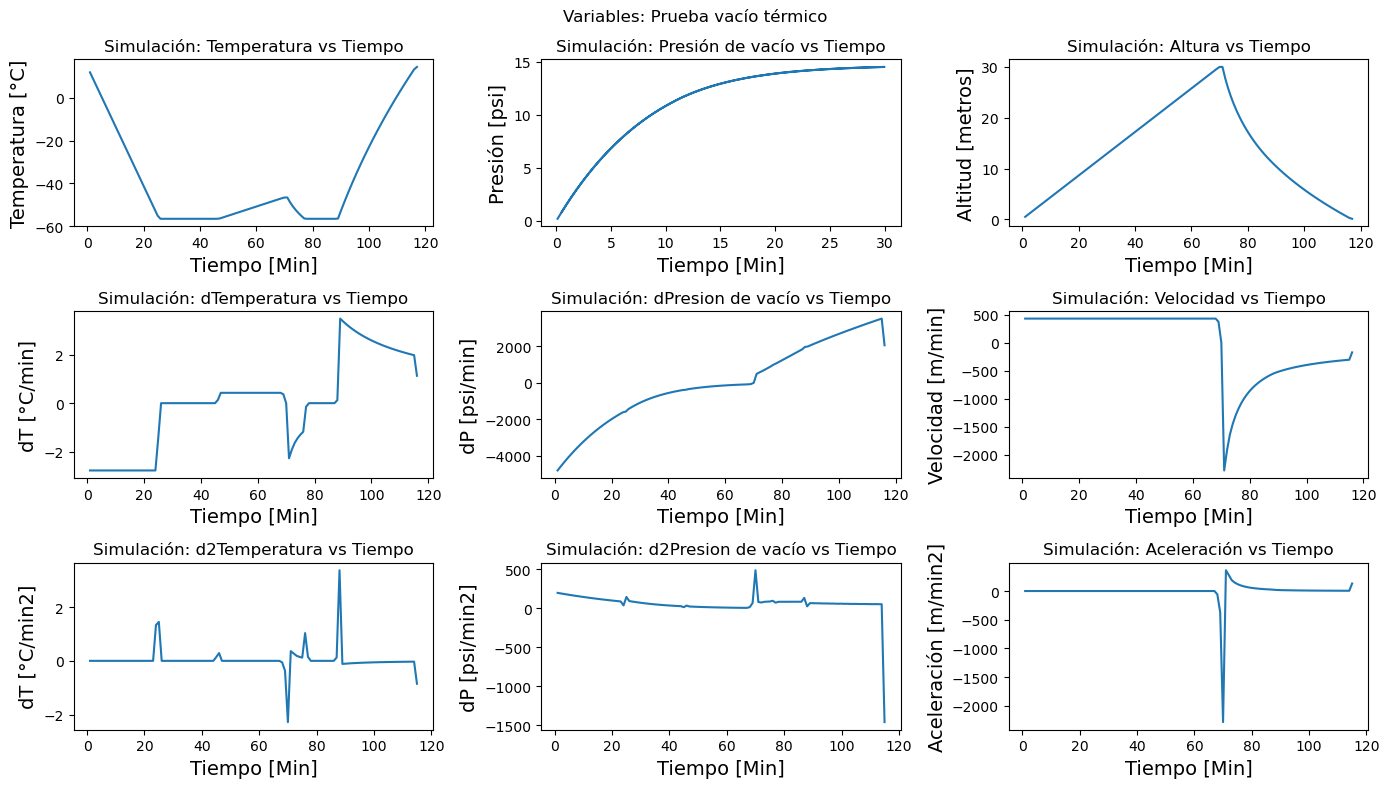


Datos: Frigorífico
--------------------------------
|     Variable       |   Valor |
--------------------------------
|   min_T    [°C]    |  -56.50 |
|   prom_T   [°C]    |  -38.01 |
|   max_T    [°C]    |  14.30  |
|   dT_min   [°C]    |  -2.78  |
|   dT_prom  [°C]    |  0.02   |
|   dT_max   [°C]    |  3.50   |
--------------------------------


Datos: Cámara de vacío
-----------------------------------
|     Variable      |    Valor    |
-----------------------------------
|   min_P    [psi]  |  14.52      |
|   prom_P   [psi]  |  10.34      |
|   max_P    [psi]  |  0.19       |
|   dP_min   [psi]  |  -0.70      |
|   dP_prom  [psi]  |  0.01       |
|   dP_max   [psi]  |  0.51       |
-----------------------------------


In [10]:
# Fecha y Hora
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("_%Y-%m-%d_%H-%M-%S")

# Cargar archivo CSV de: https://predict.sondehub.org
Data = data_upload()
sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3 = calculus(Data)

#Graphics
graphics1(formatted_datetime,sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3)
graphics2(formatted_datetime,sim_altitude,sim_time,sim_temperature,sim_pressure,v,dTT,dPP,v2,dTT2,dPP2,sim_time2,sim_time3)

#Tabla resumen
tabla_resumen(sim_temperature,sim_pressure)